In [5]:
import numpy as np
import pandas as pd
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import initializers, regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D 
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2, l1, l1_l2

## Download data

In [6]:
# To download files (if needed)
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP' -O 'x_ts_L60_Z12_A500_DX50_bias5_N10000.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FcaX9VT9PY6WWRWUU5kA4pnKQUPtS9bb' -O 'y_ts_L60_Z12_A500_DX50_bias5_N10000.csv'

--2020-03-21 18:53:49--  https://docs.google.com/uc?export=download&id=1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP
Resolving docs.google.com (docs.google.com)... 216.58.198.46, 2a00:1450:4002:802::200e
Connecting to docs.google.com (docs.google.com)|216.58.198.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jh8anarkirj6rdrn8rqi15vnm5qvccpc/1584813225000/10483148750674350960/*/1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP?e=download [following]
--2020-03-21 18:53:50--  https://doc-04-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jh8anarkirj6rdrn8rqi15vnm5qvccpc/1584813225000/10483148750674350960/*/1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP?e=download
Resolving doc-04-6k-docs.googleusercontent.com (doc-04-6k-docs.googleusercontent.com)... 216.58.205.65, 2a00:1450:4002:807::2001
Connecting to doc-04-6k-docs.googleusercontent.com (doc-04-6k-docs.googleus

## Reading and plotting data

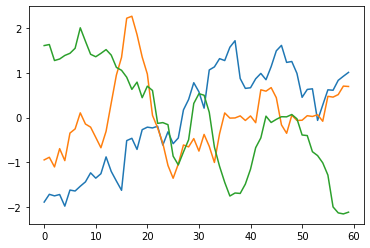

N_train = 8000   N_val =  2000   L=  60  N_class= 3


In [7]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.csv'
fnamex = 'x_'+str0
fnamey = 'y_'+str0

x = np.loadtxt(fnamex,delimiter=',',dtype=float)
N = len(x)

# scaling!
"""
Prof did this
xm = x.mean(axis=1)
for ii in range(N):
    x[ii] = x[ii] - xm[ii]
    
x = x/100
"""
# Subtract the mean of each series
xm_horiz = x.mean(axis=1)
for i in range(N):
    x[i] -= xm_horiz[i]

# Subtract the mean of each feature in order to have unbiased series
xm_vert = x.mean(axis=0)
for i in range(len(x[0])):
    x[:,i] -= xm_vert[i]
    
# Computes and divides by the standard deviation.
# A signle standard deviation is computed for all the data.
x_std = np.std(x)
x /= x_std

plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

categ = np.loadtxt(fnamey, delimiter=',',dtype=int)
n_class = 3

y = np.zeros((N,n_class))
for ii in range(N):
    y[ii][categ[ii]] = 1.

perc_train = 0.8
N_train = int(N*perc_train)

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(y_val)

L = len(x[0])  #length of each sample
print('N_train =',N_train, '  N_val = ',N_val, '  L= ',L, ' N_class=',n_class)

## Data reshaping

In [37]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

## Convolutional NN (point 1)

In [38]:
reg = keras.regularizers.l1(0.02) #l1=lasso, l2=ridge

np.random.seed(12345)

ini = keras.initializers.RandomNormal(mean=0,stddev=0.05)
#ini = keras.initializers.he_normal()


def select_CNN(NCONV):
    
    # Architecture definition
    model = Sequential(name='CNN_NCONV' + str(NCONV))
    if NCONV==1:
            #we cheat: we know Z=12 and so we put 11 here below
        model.add(Conv1D(filters=5, kernel_size=11,  #5= #of masks
                         kernel_initializer=ini,
                         kernel_regularizer=reg,
                         activation='relu',
                         input_shape=input_shape)) 
    
        model.add(AveragePooling1D(5)) #every5# -> 1# that is the < >
        model.add(Conv1D(filters=5, kernel_size=7,
                         activation='relu'))
        model.add(Flatten())
        model.add(Dense(10,activation='relu')) #'normal' layer
        model.add(Dropout(0.2))
    if NCONV==2:
        model.add(Conv1D(filters=6,
                         kernel_size=15,
                         kernel_regularizer=reg,
                         kernel_initializer=ini,
                         input_shape=input_shape))
        model.add(tf.keras.layers.PReLU(shared_axes=[1]))
        model.add(MaxPooling1D(5))
        model.add(Conv1D(filters=5,
                         kernel_size=7))
        model.add(tf.keras.layers.PReLU(shared_axes=[1]))
        model.add(Flatten())
        model.add(Dense(14))
        model.add(Dropout(0.25))
        model.add(tf.keras.layers.PReLU(shared_axes=[1]))
    if NCONV==3:
        model.add(Conv1D(filters=5,
                         kernel_size=15,
                         kernel_regularizer=reg,
                         kernel_initializer=ini,
                         input_shape=input_shape))
        model.add(tf.keras.layers.PReLU(shared_axes=[1]))
        model.add(MaxPooling1D(5))
        model.add(Flatten())
        model.add(Dense(10))
        model.add(Dropout(0.25))
        model.add(tf.keras.layers.PReLU(shared_axes=[1]))
    
    model.add(Dense(n_class,activation='softmax')) #last layer
    
    #opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True,decay=1e-6) #decay of lear. rate
    #opt = optimizers.RMSprop()
    #opt = optimizers.Nadam()
    opt = optimizers.Adam()   # this is the best optimizer
    
    #model: categorical
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt, metrics=['accuracy'])
        
    return model

## Fit

Model: "CNN_NCONV1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

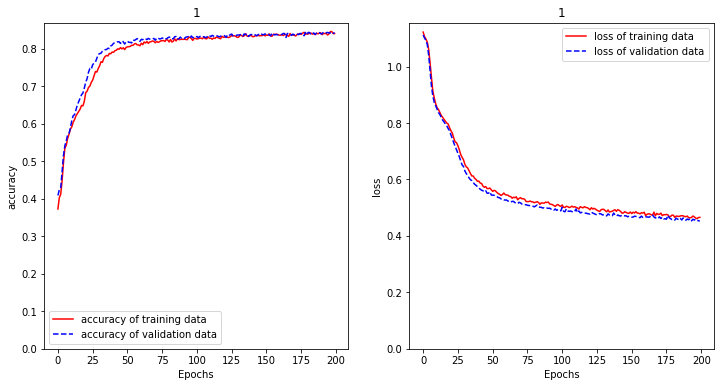

Model: "CNN_NCONV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 46, 6)             96        
_________________________________________________________________
p_re_lu (PReLU)              (None, 46, 6)             6         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 6)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 5)              215       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 3, 5)              5         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                2

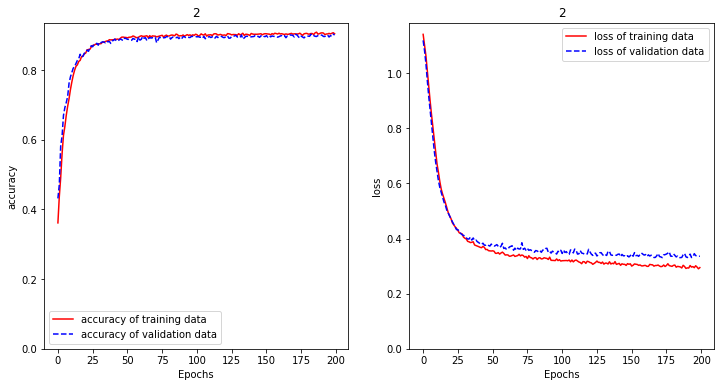

Model: "CNN_NCONV3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 46, 5)             80        
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 46, 5)             5         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 5)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                460       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 10)                1

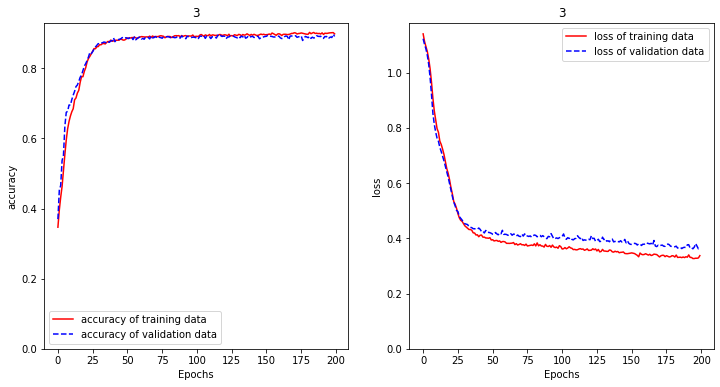

In [10]:
batch_size = 250
epochs = 200
data_for_comparison = {}
fitted_models = {}

for nconv in range(1,4):
    CNN = select_CNN(nconv)
    fit = CNN.fit(x_train,y_train,
               batch_size=batch_size, epochs=epochs,
               validation_data=(x_val,y_val),
               verbose=0, shuffle=True)              # verborse=0   -> silent fit
    
    fitted_models[nconv] = CNN
    data_for_comparison[nconv] = {'accuracy':fit.history['val_accuracy'],'loss':fit.history['val_loss']}
    
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    j=0
    for obs in ('accuracy','loss'):
        ax[j].plot(fit.history[obs],'r',
            label=obs+' of training data')
        ax[j].plot(fit.history['val_'+obs],'b--',
            label=obs+' of validation data')        
        ax[j].set_title(nconv)
        ax[j].set_xlabel('Epochs')
        ax[j].set_ylabel(obs)
        ax[j].legend()
        ax[j].set_ylim(0)
        j += 1
        
    print(CNN.summary())
    plt.show()

## CNN comparison

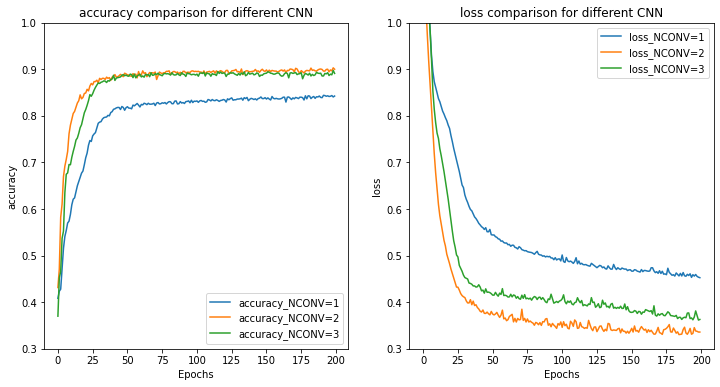

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
j=0
for obs in ['accuracy','loss']:
    for k in data_for_comparison:
        ax[j].plot(data_for_comparison[k][obs],label=obs+'_NCONV='+str(k))
        ax[j].set_title(obs + ' comparison for different CNN')
        ax[j].set_xlabel('Epochs')
        ax[j].set_ylabel(obs)
        ax[j].legend()
        ax[j].set_ylim(0.3,1)
    j += 1
plt.show()

As can be seen, using Dense layers instead ov Conv1d layers, increases a lot the number of parameters but, at the same time, increases also the performances of the model, as we can notice from the graphs above. The improvement can be brought back also to the fact that we have used PreLu as activation function.

### Plot weights of the filters in the 1st layers (model NCONV=1)

W0T= [[[-2.3199879e-01 -8.7303226e-04 -4.3408465e-04  6.1142887e-03
    8.8718072e-02  7.6753989e-02  5.7363782e-02  7.4644119e-02
    8.5880309e-02  4.6824329e-04 -1.6089460e-01]]

 [[ 8.5553492e-04  1.5520690e-02  9.3827888e-02  7.2731934e-02
    1.5200933e-03  4.4024808e-04 -2.3926904e-03 -1.2751773e-01
   -1.2324637e-01 -5.0183972e-03  1.7275871e-03]]

 [[ 4.3488439e-04 -1.5228972e-04  1.0322983e-06 -2.7135212e-04
    8.7067667e-05 -1.2362091e-04  8.2474580e-06  2.2675435e-04
    1.5612970e-04 -1.8679231e-04 -4.5554945e-05]]

 [[ 1.7577382e-02  1.1159373e-03  1.2307428e-03  1.5847302e-03
    1.9283656e-03  2.6757172e-03  3.7666969e-02  3.2717817e-02
    3.1558874e-03  3.9243057e-02  5.3656917e-02]]

 [[-1.0315844e-04 -5.5541001e-05 -8.1217804e-06 -6.9024994e-05
   -2.6870839e-04  7.3415453e-05 -1.4647775e-04 -1.9233779e-04
    1.9849409e-04  9.2076429e-05  9.2556002e-05]]]
W01= [-0.16594848 -0.16455846 -0.04906646 -0.01404945 -0.01717868]
11
5


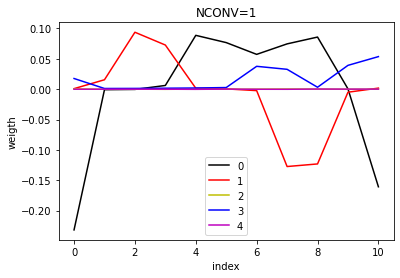

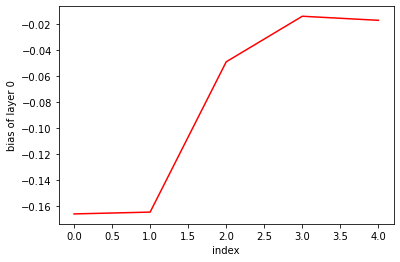

In [41]:
c = ['k','r','y','b','m']
def plot_w(w):
    #plot weights of convol. layer
    plt.figure(figsize=(6,4))
    for ii in range(len(w)):
        plt.plot(w[ii][0],c[ii],label=str(ii))
    plt.title('NCONV='+str(1))
    plt.ylabel('weigth')
    plt.xlabel('index')
    plt.legend()
    plt.show()

model1 = fitted_models[1]
w0 = model1.layers[0].get_weights()[0]
w01 = model1.layers[0].get_weights()[1]
w0T = w0.T
print('W0T=',w0T)
print('W01=',w01)
print(len(w0))
print(len(w0T))
plot_w(w0T)

plt.plot(w01, 'r',label=str(ii))
plt.ylabel('bias of layer 0')
plt.xlabel('index')
plt.show()

In the next step we are going to plot the weights of the second layer.

W0T= [[[-3.04938912e-01  1.54843271e-01  1.17075741e+00  1.30749261e+00
    8.73560071e-01 -6.34678483e-01 -1.42497504e+00]
  [-1.01643658e+00 -2.30009389e+00 -3.89556497e-01  5.29197991e-01
    5.50902367e-01  1.56240106e-01  8.76859948e-02]
  [ 1.09970257e-01  1.57049015e-01  8.41787383e-02 -1.57320082e-01
   -2.18346059e-01  6.80647567e-02 -1.11131340e-01]
  [-2.17156634e-01  3.20247084e-01 -2.90145800e-02 -8.90233368e-02
   -7.76253715e-02 -2.28489012e-01 -3.03750247e-01]
  [ 2.48630077e-01 -4.37825732e-02  6.59409240e-02  1.69056147e-01
    1.49413660e-01 -1.68016389e-01 -9.70514417e-02]]

 [[ 9.93891656e-01  5.56012750e-01  3.76641184e-01 -6.95542753e-01
    3.12341806e-02  6.89305186e-01  1.13873482e+00]
  [-1.27933592e-01  7.31414676e-01  1.57967180e-01 -2.61877239e-01
   -3.91792446e-01  2.13925526e-01  1.82801232e-01]
  [ 2.41537571e-01  2.88287662e-02 -1.31803662e-01  2.37993836e-01
   -1.64541915e-01  1.88591719e-01 -2.92478278e-02]
  [ 2.52429366e-01  6.10940196e-02 -3.718

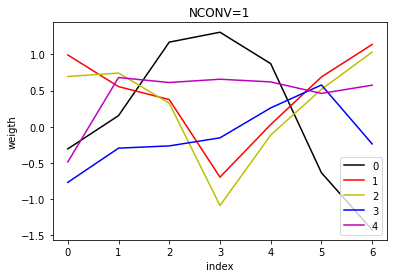

Text(0.5, 0, 'index')

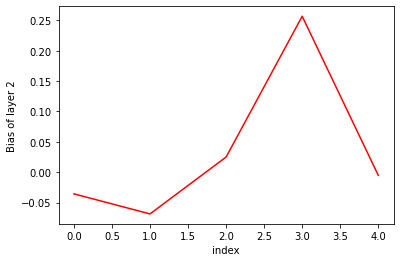

In [46]:
w0_2 = model1.layers[2].get_weights()[0]
w01_2 = model1.layers[2].get_weights()[1]
w0T_2 = w0_2.T
print('W0T=',w0T_2)
print('W01=',w01_2)
print(len(w0_2))
print(len(w0T_2))
plot_w(w0T_2)

plt.plot(w01_2, 'r',label=str(ii))
plt.ylabel('Bias of layer 2')
plt.xlabel('index')

## Confusion Matrix  (point 2)

Confusion matrix for the model NCONV=1

Confusion matrix of the model: 
 [[516  59  92]
 [255 299 112]
 [265  70 332]]
Normalized confusion matrix of the model: 
 [[0.77361319 0.08845577 0.13793103]
 [0.38288288 0.44894895 0.16816817]
 [0.39730135 0.10494753 0.49775112]]


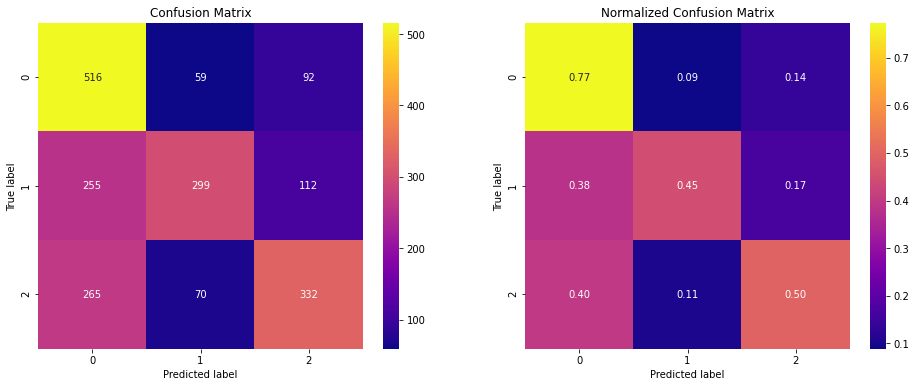

Confusion matrix for the model NCONV=2

Confusion matrix of the model: 
 [[510  59  98]
 [227 329 110]
 [211  56 400]]
Normalized confusion matrix of the model: 
 [[0.76461769 0.08845577 0.14692654]
 [0.34084084 0.49399399 0.16516517]
 [0.31634183 0.08395802 0.59970015]]


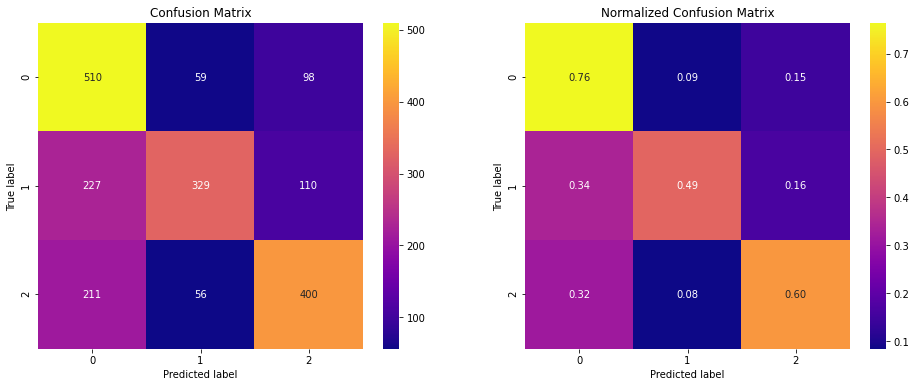

Confusion matrix for the model NCONV=3

Confusion matrix of the model: 
 [[557  58  52]
 [280 320  66]
 [286  51 330]]
Normalized confusion matrix of the model: 
 [[0.83508246 0.08695652 0.07796102]
 [0.42042042 0.48048048 0.0990991 ]
 [0.42878561 0.07646177 0.49475262]]


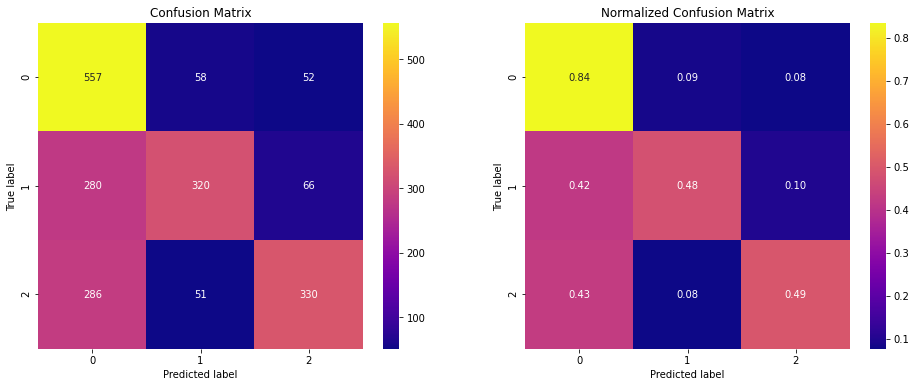

In [66]:
#Confusion Matrix (on the validation set)

def maplabels(l):
    if   (l == [1,0,0]).all(): return 0
    elif (l == [0,1,0]).all(): return 1
    elif (l == [0,0,1]).all(): return 2
    else: print("Error", l)
    return

for nconv in range(1,4):
    
    print('Confusion matrix for the model NCONV=' + str(nconv) + '\n')

    model2 = fitted_models[nconv]

    fig, ax = plt.subplots(1,2,figsize=(16,6))
    labels = np.apply_along_axis(maplabels,1,y_val)
    model_y = np.around(model2.predict(x_val)).astype('int')
    predictions = model2.predict(x_val).argmax(axis=-1)

    _, counts = np.unique(labels, return_counts=True)

    conf_mat = confusion_matrix(labels,predictions)

    print("Confusion matrix of the model: \n", conf_mat)
    print("Normalized confusion matrix of the model: \n", conf_mat/counts[:,None])

    df_cm = pd.DataFrame(conf_mat, index = [0,1,2], columns = [0,1,2])
    df_cm_norm = pd.DataFrame(conf_mat/counts, index = [0,1,2], columns = [0,1,2])

    sns.heatmap(df_cm, annot=True, cmap="plasma", fmt="d",ax=ax[0])
    ax[0].set_xlabel("Predicted label")
    ax[0].set_ylabel("True label")
    ax[0].set_title("Confusion Matrix")
    
    sns.heatmap(df_cm_norm, annot=True, cmap="plasma", fmt=".2f",ax=ax[1])
    ax[1].set_xlabel("Predicted label")
    ax[1].set_ylabel("True label")
    ax[1].set_title("Normalized Confusion Matrix")
    
    plt.show()

## Regularization study (point 3)

In [94]:
def model_(l, params):
    ini = keras.initializers.he_normal()
    model = Sequential()
    
    if l == l1 or l == l2:
        model.add(Conv1D(filters=5, kernel_size=11,  #5= #of masks
                      kernel_initializer=ini,
                      kernel_regularizer=  l(params),
                      activation='relu',
                     input_shape=input_shape)) 
        model.add(AveragePooling1D(5)) #every5# -> 1# that is the < >
        model.add(Conv1D(filters=5, kernel_size=7, kernel_regularizer=  l(params),
                        activation='relu'))
        model.add(Flatten())
        model.add(Dense(10,activation='relu', kernel_regularizer=  l(params))) #'normal' layer
        model.add(Dropout(0.2))
        model.add(Dense(n_class,activation='softmax', kernel_regularizer=  l(params))) #last layer
    elif l == l1_l2:
        model.add(Conv1D(filters=5, kernel_size=11,  #5= #of masks
                      kernel_initializer=ini,
                      kernel_regularizer=  l(params, params),
                      activation='relu',
                     input_shape=input_shape)) 
        model.add(AveragePooling1D(5)) #every5# -> 1# that is the < >
        model.add(Conv1D(filters=5, kernel_size=7, kernel_regularizer=  l(params, params),
                        activation='relu'))
        model.add(Flatten())
        model.add(Dense(10,activation='relu', kernel_regularizer=  l(params, params))) #'normal' layer
        model.add(Dropout(0.2))
        model.add(Dense(n_class,activation='softmax', kernel_regularizer=  l(params, params))) #last layer
        
    #print(model.summary())

    #opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True,decay=1e-6) #decay of lear. rate
    #opt = optimizers.RMSprop()
    #opt = optimizers.Nadam()
    opt = optimizers.Adam()

    #model: categorical
    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=opt, metrics=['accuracy'])
    return model

In [95]:
l =  [l1, l2, l1_l2]
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

batch_size = 250
epochs = 100


# Performance gatherers
train_accuracies = [[],[],[]]
val_accuracies = [[],[],[]]
train_losses = [[],[],[]]
val_losses = [[],[],[]]

counter = 0

s = 0
for ls in l: 
    for params in values:
        model = model_(ls, params) # Creating the model
        # Training the model
        fit = model.fit(x_train,y_train,
                   batch_size=batch_size, epochs=epochs,
                   validation_data=(x_val,y_val),
                   verbose=0, shuffle=True)                # verbose=0   -> silent fit

        # Storing the performances
        train_accuracies[s].append(fit.history['accuracy'])
        val_accuracies[s].append(fit.history['val_accuracy'])
        train_losses[s].append(fit.history['loss'])
        val_losses[s].append(fit.history['val_loss'])
    s += 1

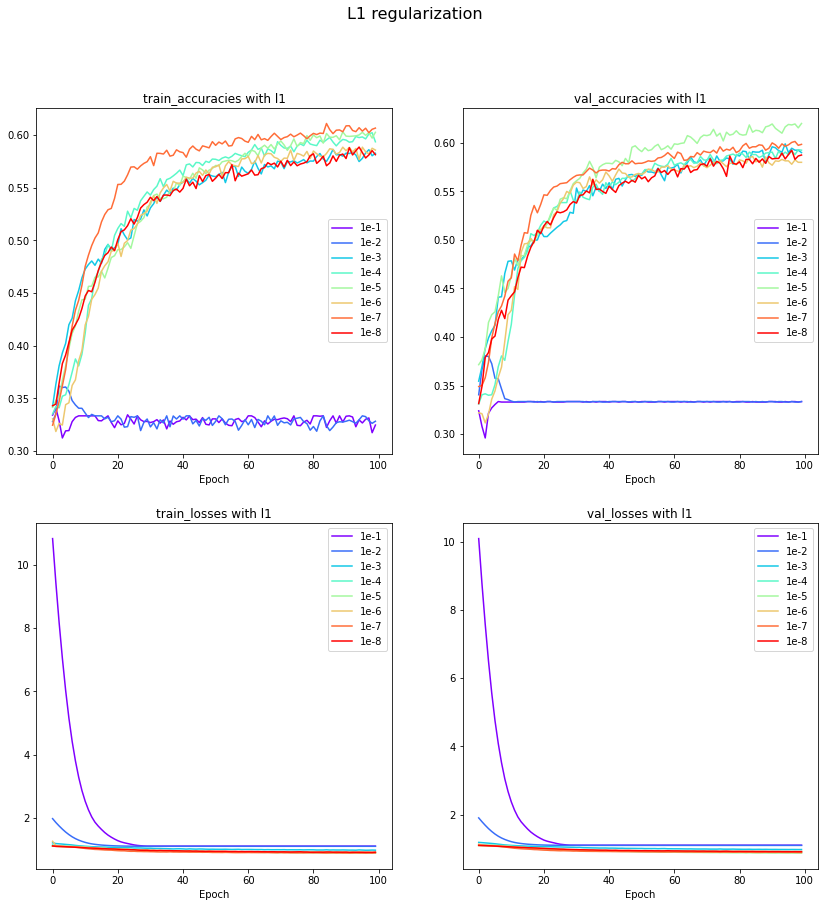

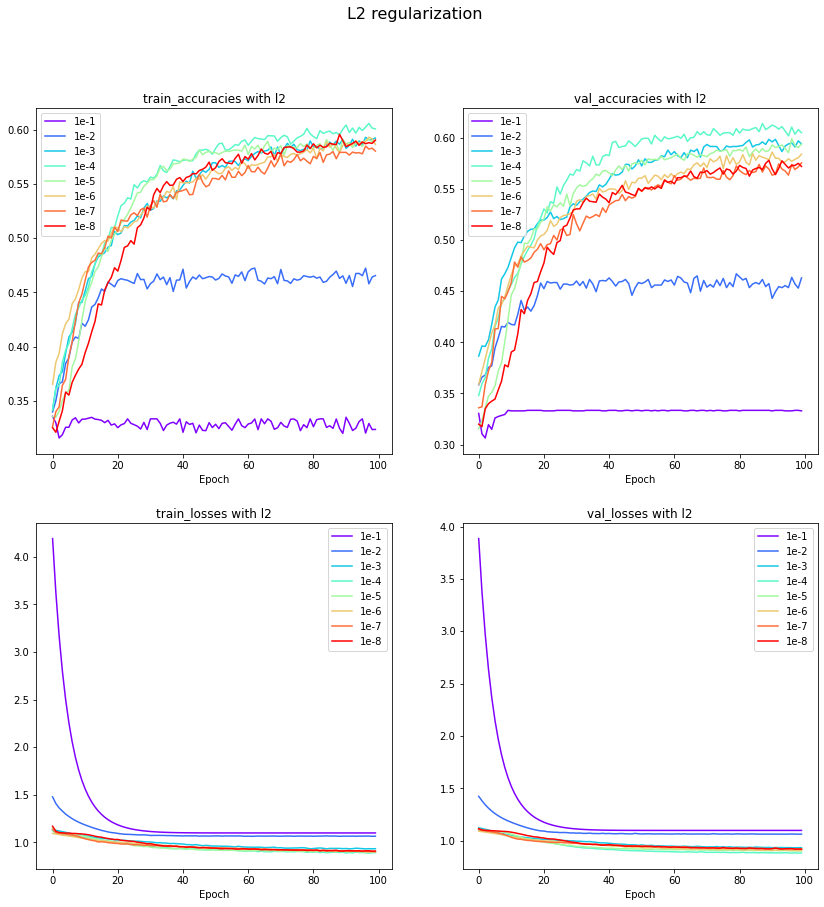

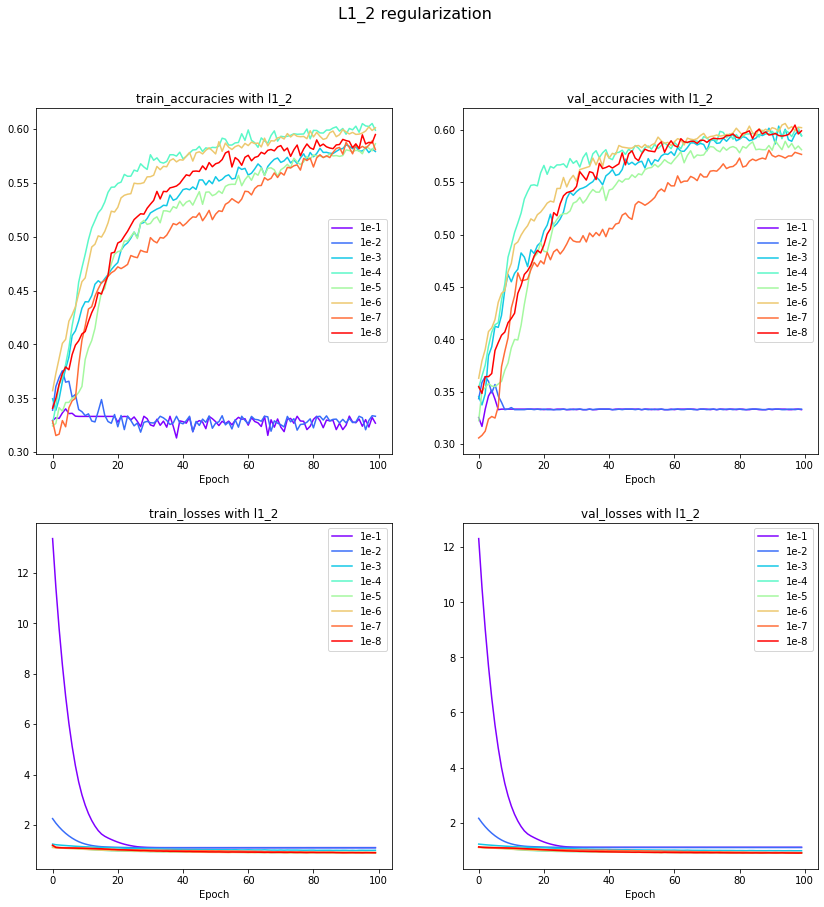

In [96]:
plots = [train_accuracies[0], val_accuracies[0], train_losses[0], val_losses[0]]
titles = ['train_accuracies with l1', 'val_accuracies with l1', 'train_losses with l1', 'val_losses with l1']

plots1 = [train_accuracies[1], val_accuracies[1], train_losses[1], val_losses[1]]
titles1 = ['train_accuracies with l2', 'val_accuracies with l2', 'train_losses with l2', 'val_losses with l2']

plots2 = [train_accuracies[2], val_accuracies[2], train_losses[2], val_losses[2]]
titles2 = ['train_accuracies with l1_2', 'val_accuracies with l1_2', 'train_losses with l1_2', 'val_losses with l1_2']

fig, axs = plt.subplots(2,2, figsize=(14,14))
colors = plt.cm.rainbow(np.linspace(0,1,len(plots[0])))

# Plotting the performances for each set of parameters

for i in range(len(plots)):
    ax = axs[int((i-i%2)/2), i%2]
    for j in range(len(plots[i])):
        ax.plot(np.arange(epochs), plots[i][j], color = colors[j], label=j)
    ax.set_title(titles[i])
    ax.set_xlabel('Epoch')
    ax.legend(["1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6", "1e-7", "1e-8" ])
fig.suptitle('L1 regularization', fontsize=16)

plt.show()

fig, axs = plt.subplots(2,2, figsize=(14,14))
colors = plt.cm.rainbow(np.linspace(0,1,len(plots[0])))

# Plotting the performances for each set of parameters
for i in range(len(plots1)):
    ax = axs[int((i-i%2)/2), i%2]
    for j in range(len(plots1[i])):
        ax.plot(np.arange(epochs), plots1[i][j], color = colors[j], label=j)
    ax.set_title(titles1[i])
    ax.set_xlabel('Epoch')
    ax.legend(["1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6", "1e-7", "1e-8" ])
fig.suptitle('L2 regularization', fontsize=16)

plt.show()
fig, axs = plt.subplots(2,2, figsize=(14,14))
colors = plt.cm.rainbow(np.linspace(0,1,len(plots[0])))

# Plotting the performances for each set of parameters
for i in range(len(plots2)):
    ax = axs[int((i-i%2)/2), i%2]
    for j in range(len(plots2[i])):
        ax.plot(np.arange(epochs), plots2[i][j], color = colors[j], label=j)
    ax.set_title(titles2[i])
    ax.set_xlabel('Epoch')
    ax.legend(["1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6", "1e-7", "1e-8" ])
fig.suptitle('L1_2 regularization', fontsize=16)
plt.show()

Regarding the type of regularization (l1, l2, or l1_l2) it can be seen that the best lambda value is between $[10e^{-7},10e^{-5}]$ . After 20 epochs it can be seen that it converge to the same value. Now we are going to see

In [70]:
ll =  [l1, l2, l1_l2]
values = [ 1e-3, 1e-5, 1e-6, 1e-7]
weights = [[],[],[]] 
bias = [[],[],[]] 
i = 0
for ls in ll:
    for paramss in values:
        model_1 = model_(ls, paramss)
        # Training the model
        fit = model_1.fit(x_train,y_train,
               batch_size=batch_size, epochs=epochs,
               validation_data=(x_val,y_val),
               verbose=0, shuffle=True)
        w0_2 = model_1.layers[2].get_weights()[0]
        w01_2 = model_1.layers[2].get_weights()[1]  
        w0T_2 = w0_2.T
        
        weights[i].append(w0T_2)
        bias[i].append(w01_2)
    i += 1

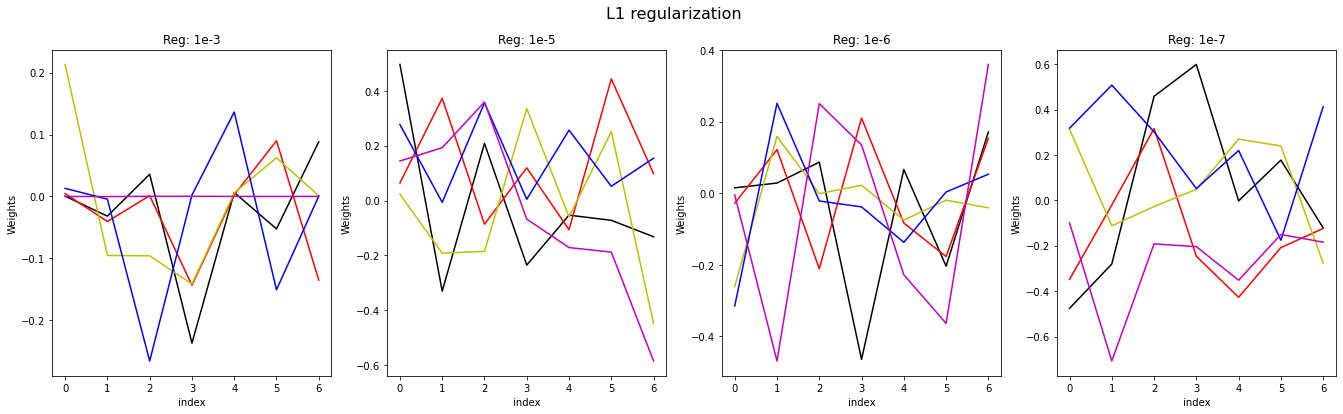

In [77]:
title = ["Reg: 1e-3", "Reg: 1e-5", "Reg: 1e-6", "Reg: 1e-7"]
plots = [weights[0], bias[0]]
titles = ['weights with l1', 'bias with l1']

plots1 = [weights[1], bias[1]]
titles1 = ['weights with l2', 'bias with l2']

plots2 = [weights[2], bias[2]]
titles2 = ['weights with l1_l2', 'bias with l1_l2']
    

figp, axp = plt.subplots(1,4, figsize=(23,6))
figp.suptitle('L1 regularization', fontsize=16)
for j in range(4):
    for ii in range(len(plots[0][j])):
        axp[j].plot(plots[0][j][ii][0],c[ii],label=str(ii))
    axp[j].set_ylabel('Weights')
    axp[j].set_title(title[j])
    axp[j].set_xlabel('index')
plt.show()

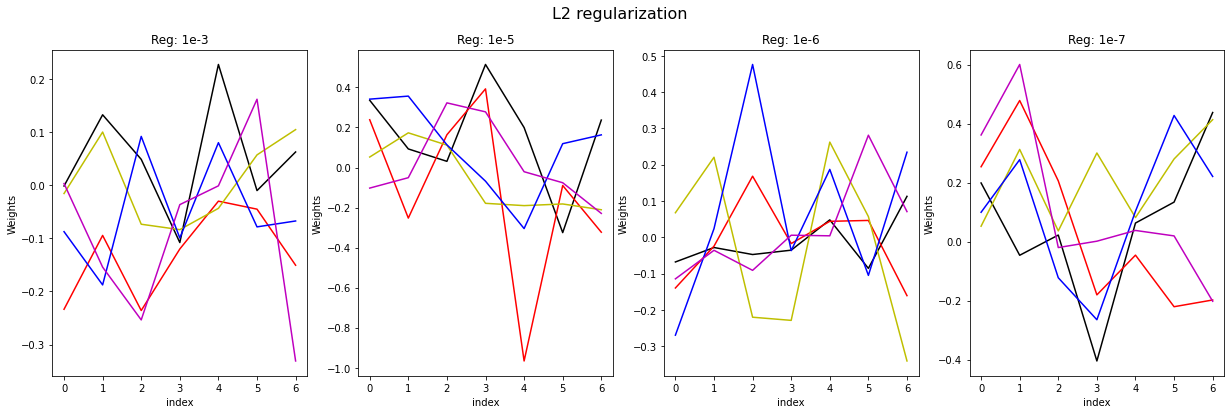

In [85]:
figp, axp = plt.subplots(1,4, figsize=(21,6))
figp.suptitle('L2 regularization', fontsize=16)
for j in range(4):
    for ii in range(len(plots1[0][j])):
        axp[j].plot(plots1[0][j][ii][0],c[ii],label=str(ii))
    axp[j].set_ylabel('Weights')
    axp[j].set_title(title[j])
    axp[j].set_xlabel('index')
plt.show()

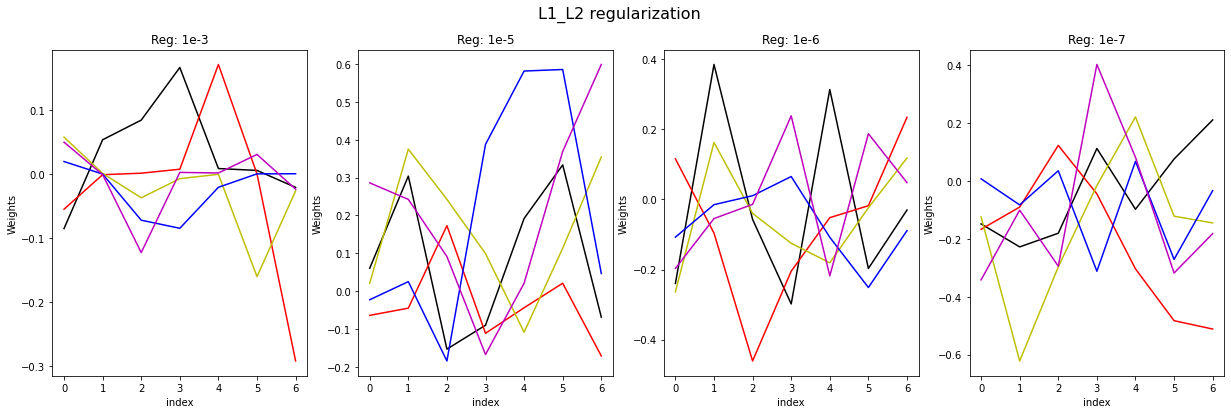

In [84]:
figp, axp = plt.subplots(1,4, figsize=(21,6))
figp.suptitle('L1_L2 regularization', fontsize=16)
for j in range(4):
    for ii in range(len(plots2[0][j])):
        axp[j].plot(plots2[0][j][ii][0],c[ii],label=str(ii))
    axp[j].set_ylabel('Weights')
    axp[j].set_title(title[j])
    axp[j].set_xlabel('index')
plt.show()

In [22]:
bias[0]

[array([-0.16708449, -0.16036546, -0.29926664,  0.05983932, -0.3390087 ],
       dtype=float32),
 array([-0.32370454, -0.5477459 , -0.3887689 , -0.27680513, -0.395868  ],
       dtype=float32),
 array([ 0.4809588 ,  0.30130017, -0.1451845 , -0.02941298, -0.41891667],
       dtype=float32),
 array([ 0.30124095, -0.15660296, -0.13836512, -0.27517757, -0.12842739],
       dtype=float32)]

In [23]:
bias[1]

[array([-0.35438552, -0.32930177, -0.44306433, -0.14719702, -0.3089522 ],
       dtype=float32),
 array([-0.24332976, -0.08683504,  0.63348806, -0.26744282, -0.26681414],
       dtype=float32),
 array([-0.26290902, -0.20983557, -0.3504685 , -0.22983985, -0.21892071],
       dtype=float32),
 array([-0.266866  , -0.037717  , -0.30369145,  0.15436019,  0.43587273],
       dtype=float32)]

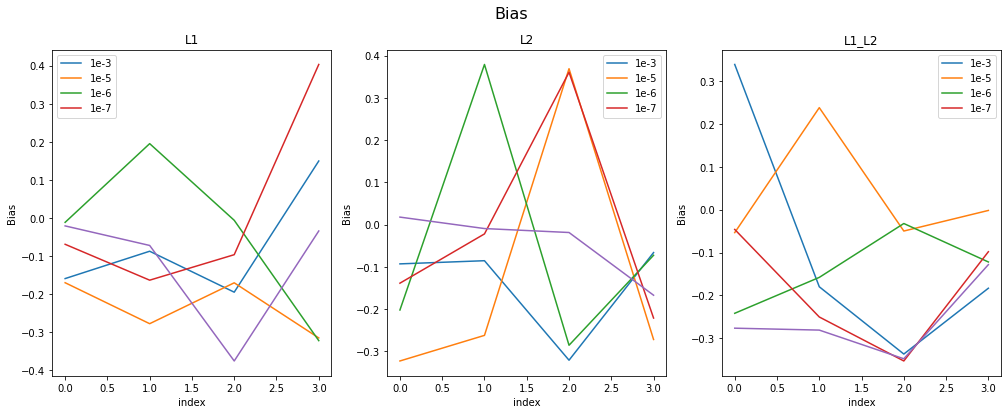

In [86]:
types = ["L1", "L2", "L1_L2"]
figp, axp = plt.subplots(1,3, figsize=(17,6))
figp.suptitle('Bias', fontsize=16)
for j in range(3):
    axp[j].plot(bias[j])
    axp[j].set_ylabel('Bias')
    axp[j].set_title(types[j])
    axp[j].legend(["1e-3", "1e-5", "1e-6", "1e-7"])
    axp[j].set_xlabel('index')
plt.show()

In [87]:
ll =  [l1, l2, l1_l2]
values = [ 1, 0.2, 0.5, 1e-6, 1e-7]
weights = [[],[],[]] 
bias = [[],[],[]] 
i = 0
for ls in ll:
    for paramss in values:
        model_1 = model_(ls, paramss)
        # Training the model
        fit = model_1.fit(x_train,y_train,
               batch_size=batch_size, epochs=epochs,
               validation_data=(x_val,y_val),
               verbose=0, shuffle=True)
        w0_2 = model_1.layers[2].get_weights()[0]
        w01_2 = model_1.layers[2].get_weights()[1]  
        w0T_2 = w0_2.T
        
        weights[i].append(w0T_2)
        bias[i].append(w01_2)
    i += 1

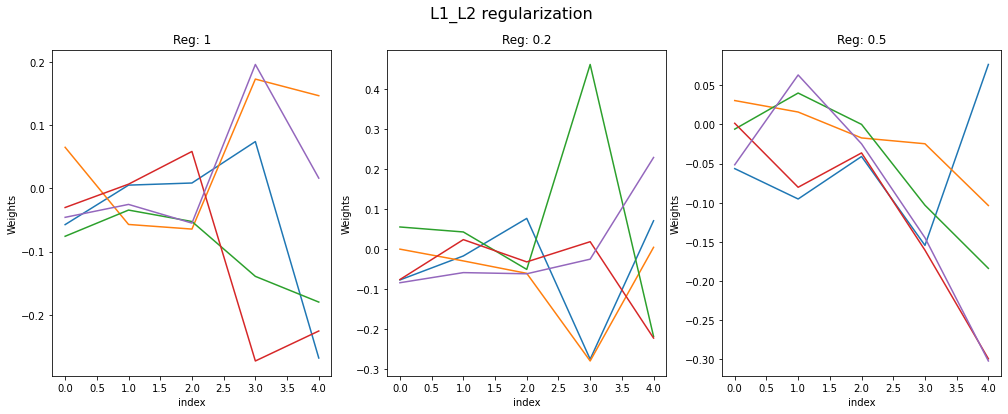

In [93]:
title = [ "Reg: 1", "Reg: 0.2", "Reg: 0.5", "1e-6", "1e-7"]
figp, axp = plt.subplots(1,3, figsize=(17,6))
figp.suptitle('L1_L2 regularization', fontsize=16)
for j in range(3):
    axp[j].plot(bias[j])
    axp[j].set_ylabel('Weights')
    axp[j].set_title(title[j])
    axp[j].set_xlabel('index')
plt.show()

## Test on different data (point 4)

In [27]:
# I'm re-writing the data generation so I can freely modify the parameters without creating too many data files
random.seed(12345)


def data_generation(amplitude, dx_step, bias_step):
    
    ######################################## SAMPLE GENERATION ##############################################
    
    dx = lambda DX, bias: int((math.log(random.random())*DX)*2*(random.randint(0,1)-0.5)+bias)
    def pattern(i,z,a):
        return int(a*math.sin((math.pi*i)/z))
    # Parameters
    A = amplitude
    Z = 12
    L = 60
    N = 10000
    DX = dx_step
    bias = bias_step
    y = [0]*N
    x = [[0]*L for i in range(N)]
    for i in range(N):
        if i>0:
            x[i][0] = x[i-1][-1]
        for j in range(1,L):
            x[i][j] = x[i][j-1] + dx(DX,bias)
        y[i] = i%3
        if y[i]>0:
            j0 = random.randint(0,L-1-Z)
            sign = 3-2*y[i]
            for j in range(Z):
                x[i][j0+j] += sign*pattern(j,Z,A)
    
    x = np.array(x,dtype='float64').reshape(N,L)      
    xm_horiz = x.mean(axis=1)
    for i in range(N):
        x[i] -= xm_horiz[i]
    xm_vert = x.mean(axis=0)
    for i in range(len(x[0])):
        x[:,i] -= xm_vert[i]
    x_std = np.std(x)
    x /= x_std

    categ = y
    n_class = 3
    y = np.zeros((N,n_class))
    for ii in range(N):
        y[ii][categ[ii]] = 1.

    perc_train = 0.8
    N_train = int(N*perc_train)

    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(y_val)
    
    print('N_train =',N_train, '  N_val = ',N_val, '  L= ',L, ' N_class=',n_class)
    
    return [x_train,y_train],[x_val,y_val]

#training_data, validation_data = data_generation(amplitude=500, dx_step=50, bias_step=5)

# Possible signal-to-noise ratio parameters
A = [600,500,400,300]
DX = [50]
bias = [5]

L = 60    
batch_size = 250
epochs = 200

data = {}
plots = {}
keys = []

for amp in A:
    for dx in DX:
        for b in bias:
            training_data, validation_data = data_generation(amplitude=amp, dx_step=dx, bias_step=b)
            
            # Storing data in a dictionary for representation
            data[f'A_{amp}_DX_{dx}_bias_{b}_x'] = np.concatenate([training_data[0],validation_data[0]])
            x_train = training_data[0].reshape(training_data[0].shape[0],L,1)
            x_val = validation_data[0].reshape(validation_data[0].shape[0],L,1)
            
            model_chosen = select_CNN(1) 
            print(model_chosen.summary())
            fit = model_chosen.fit(x_train,training_data[1],
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,validation_data[1]),
                            verbose=1, shuffle=True)
            for obs in ['accuracy', 'loss']:
                key = f'A_{amp}_DX_{dx}_bias_{b}' + '_val_' + obs
                plots[key] = fit.history['val_' + obs]
                keys.append(key)

N_train = 8000   N_val =  2000   L=  60  N_class= 3
Model: "CNN_NCONV1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_107 (Conv1D)          (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_52 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 4, 5)              180       
_________________________________________________________________
flatten_54 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_54 (Dropout)         (None, 10)                0         
_________________________________________________________________
dens

Epoch 47/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.3695 - accuracy: 0.8899 - val_loss: 0.3497 - val_accuracy: 0.8945
Epoch 48/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.3654 - accuracy: 0.8950 - val_loss: 0.3482 - val_accuracy: 0.8975
Epoch 49/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.3664 - accuracy: 0.8954 - val_loss: 0.3513 - val_accuracy: 0.8950
Epoch 50/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.3630 - accuracy: 0.8944 - val_loss: 0.3528 - val_accuracy: 0.8925
Epoch 51/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.3614 - accuracy: 0.8939 - val_loss: 0.3433 - val_accuracy: 0.8975
Epoch 52/200
8000/8000 [==============================] - 0s 57us/sample - loss: 0.3555 - accuracy: 0.8980 - val_loss: 0.3419 - val_accuracy: 0.8985
Epoch 53/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.3553 - accuracy: 0.8978

Epoch 102/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2952 - accuracy: 0.9128 - val_loss: 0.2990 - val_accuracy: 0.9135
Epoch 103/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2954 - accuracy: 0.9139 - val_loss: 0.3017 - val_accuracy: 0.9115
Epoch 104/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2952 - accuracy: 0.9153 - val_loss: 0.2911 - val_accuracy: 0.9145
Epoch 105/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2930 - accuracy: 0.9143 - val_loss: 0.2987 - val_accuracy: 0.9140
Epoch 106/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2923 - accuracy: 0.9156 - val_loss: 0.2910 - val_accuracy: 0.9145
Epoch 107/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.2941 - accuracy: 0.9181 - val_loss: 0.2910 - val_accuracy: 0.9145
Epoch 108/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2895 - accuracy:

8000/8000 [==============================] - 0s 57us/sample - loss: 0.2361 - accuracy: 0.9325 - val_loss: 0.2333 - val_accuracy: 0.9315
Epoch 157/200
8000/8000 [==============================] - 0s 57us/sample - loss: 0.2279 - accuracy: 0.9375 - val_loss: 0.2317 - val_accuracy: 0.9335
Epoch 158/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.2214 - accuracy: 0.9365 - val_loss: 0.2308 - val_accuracy: 0.9345
Epoch 159/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.2298 - accuracy: 0.9365 - val_loss: 0.2482 - val_accuracy: 0.9275
Epoch 160/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.2274 - accuracy: 0.9349 - val_loss: 0.2366 - val_accuracy: 0.9345
Epoch 161/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.2284 - accuracy: 0.9362 - val_loss: 0.2287 - val_accuracy: 0.9360
Epoch 162/200
8000/8000 [==============================] - 1s 66us/sample - loss: 0.2262 - accuracy: 0.9385 - val_

8000/8000 [==============================] - 2s 271us/sample - loss: 1.1298 - accuracy: 0.3965 - val_loss: 1.1169 - val_accuracy: 0.4480
Epoch 2/200
8000/8000 [==============================] - 1s 67us/sample - loss: 1.1070 - accuracy: 0.4265 - val_loss: 1.0967 - val_accuracy: 0.4765
Epoch 3/200
8000/8000 [==============================] - 1s 78us/sample - loss: 1.0823 - accuracy: 0.4742 - val_loss: 1.0690 - val_accuracy: 0.4970
Epoch 4/200
8000/8000 [==============================] - 1s 99us/sample - loss: 1.0518 - accuracy: 0.5134 - val_loss: 1.0355 - val_accuracy: 0.5380
Epoch 5/200
8000/8000 [==============================] - 1s 87us/sample - loss: 1.0176 - accuracy: 0.5375 - val_loss: 0.9993 - val_accuracy: 0.5715
Epoch 6/200
8000/8000 [==============================] - 1s 82us/sample - loss: 0.9797 - accuracy: 0.5711 - val_loss: 0.9640 - val_accuracy: 0.5880
Epoch 7/200
8000/8000 [==============================] - 1s 86us/sample - loss: 0.9474 - accuracy: 0.5929 - val_loss: 0.934

8000/8000 [==============================] - 1s 78us/sample - loss: 0.5037 - accuracy: 0.8339 - val_loss: 0.4915 - val_accuracy: 0.8280
Epoch 57/200
8000/8000 [==============================] - 1s 84us/sample - loss: 0.5046 - accuracy: 0.8336 - val_loss: 0.4867 - val_accuracy: 0.8340
Epoch 58/200
8000/8000 [==============================] - 1s 77us/sample - loss: 0.4965 - accuracy: 0.8357 - val_loss: 0.4933 - val_accuracy: 0.8265
Epoch 59/200
8000/8000 [==============================] - 1s 72us/sample - loss: 0.4979 - accuracy: 0.8366 - val_loss: 0.4871 - val_accuracy: 0.8350
Epoch 60/200
8000/8000 [==============================] - 1s 76us/sample - loss: 0.4884 - accuracy: 0.8401 - val_loss: 0.4839 - val_accuracy: 0.8370
Epoch 61/200
8000/8000 [==============================] - 1s 98us/sample - loss: 0.4839 - accuracy: 0.8438 - val_loss: 0.4780 - val_accuracy: 0.8370
Epoch 62/200
8000/8000 [==============================] - 1s 75us/sample - loss: 0.4827 - accuracy: 0.8407 - val_loss: 

Epoch 111/200
8000/8000 [==============================] - 1s 71us/sample - loss: 0.4015 - accuracy: 0.8741 - val_loss: 0.4049 - val_accuracy: 0.8715
Epoch 112/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.3944 - accuracy: 0.8746 - val_loss: 0.3922 - val_accuracy: 0.8775
Epoch 113/200
8000/8000 [==============================] - 1s 63us/sample - loss: 0.3874 - accuracy: 0.8780 - val_loss: 0.3900 - val_accuracy: 0.8740
Epoch 114/200
8000/8000 [==============================] - 1s 64us/sample - loss: 0.3915 - accuracy: 0.8795 - val_loss: 0.3900 - val_accuracy: 0.8795
Epoch 115/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.3923 - accuracy: 0.8744 - val_loss: 0.3995 - val_accuracy: 0.8750
Epoch 116/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.3915 - accuracy: 0.8764 - val_loss: 0.3874 - val_accuracy: 0.8770
Epoch 117/200
8000/8000 [==============================] - 1s 67us/sample - loss: 0.3936 - accuracy:

8000/8000 [==============================] - 1s 65us/sample - loss: 0.3764 - accuracy: 0.8804 - val_loss: 0.3789 - val_accuracy: 0.8845
Epoch 166/200
8000/8000 [==============================] - 1s 69us/sample - loss: 0.3715 - accuracy: 0.8823 - val_loss: 0.3679 - val_accuracy: 0.8895
Epoch 167/200
8000/8000 [==============================] - 1s 66us/sample - loss: 0.3735 - accuracy: 0.8845 - val_loss: 0.3710 - val_accuracy: 0.8885
Epoch 168/200
8000/8000 [==============================] - 1s 68us/sample - loss: 0.3709 - accuracy: 0.8816 - val_loss: 0.3698 - val_accuracy: 0.8890
Epoch 169/200
8000/8000 [==============================] - 1s 72us/sample - loss: 0.3768 - accuracy: 0.8849 - val_loss: 0.3638 - val_accuracy: 0.8855
Epoch 170/200
8000/8000 [==============================] - 1s 69us/sample - loss: 0.3763 - accuracy: 0.8836 - val_loss: 0.3833 - val_accuracy: 0.8825
Epoch 171/200
8000/8000 [==============================] - 1s 69us/sample - loss: 0.3748 - accuracy: 0.8790 - val_

8000/8000 [==============================] - 1s 79us/sample - loss: 1.0987 - accuracy: 0.3473 - val_loss: 1.0987 - val_accuracy: 0.3720
Epoch 11/200
8000/8000 [==============================] - 1s 79us/sample - loss: 1.0985 - accuracy: 0.3528 - val_loss: 1.0985 - val_accuracy: 0.3545
Epoch 12/200
8000/8000 [==============================] - 1s 75us/sample - loss: 1.0983 - accuracy: 0.3550 - val_loss: 1.0982 - val_accuracy: 0.3720
Epoch 13/200
8000/8000 [==============================] - 1s 76us/sample - loss: 1.0980 - accuracy: 0.3595 - val_loss: 1.0976 - val_accuracy: 0.3480
Epoch 14/200
8000/8000 [==============================] - 1s 68us/sample - loss: 1.0969 - accuracy: 0.3587 - val_loss: 1.0969 - val_accuracy: 0.3635
Epoch 15/200
8000/8000 [==============================] - 1s 63us/sample - loss: 1.0955 - accuracy: 0.3699 - val_loss: 1.0956 - val_accuracy: 0.3685
Epoch 16/200
8000/8000 [==============================] - 1s 69us/sample - loss: 1.0940 - accuracy: 0.3705 - val_loss: 

8000/8000 [==============================] - 1s 65us/sample - loss: 0.8874 - accuracy: 0.5987 - val_loss: 0.8794 - val_accuracy: 0.6015
Epoch 66/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.8832 - accuracy: 0.5944 - val_loss: 0.8759 - val_accuracy: 0.6025
Epoch 67/200
8000/8000 [==============================] - 0s 59us/sample - loss: 0.8887 - accuracy: 0.5918 - val_loss: 0.8792 - val_accuracy: 0.6000
Epoch 68/200
8000/8000 [==============================] - 1s 67us/sample - loss: 0.8860 - accuracy: 0.5943 - val_loss: 0.8842 - val_accuracy: 0.5940
Epoch 69/200
8000/8000 [==============================] - 1s 83us/sample - loss: 0.8817 - accuracy: 0.5932 - val_loss: 0.8770 - val_accuracy: 0.5985
Epoch 70/200
8000/8000 [==============================] - 1s 63us/sample - loss: 0.8795 - accuracy: 0.6031 - val_loss: 0.8901 - val_accuracy: 0.5820
Epoch 71/200
8000/8000 [==============================] - 1s 71us/sample - loss: 0.8863 - accuracy: 0.5965 - val_loss: 

Epoch 120/200
8000/8000 [==============================] - 1s 69us/sample - loss: 0.8589 - accuracy: 0.6148 - val_loss: 0.8513 - val_accuracy: 0.6245
Epoch 121/200
8000/8000 [==============================] - 1s 70us/sample - loss: 0.8544 - accuracy: 0.6118 - val_loss: 0.8468 - val_accuracy: 0.6295
Epoch 122/200
8000/8000 [==============================] - 1s 74us/sample - loss: 0.8504 - accuracy: 0.6216 - val_loss: 0.8458 - val_accuracy: 0.6310
Epoch 123/200
8000/8000 [==============================] - 1s 80us/sample - loss: 0.8478 - accuracy: 0.6245 - val_loss: 0.8478 - val_accuracy: 0.6265
Epoch 124/200
8000/8000 [==============================] - 1s 67us/sample - loss: 0.8458 - accuracy: 0.6208 - val_loss: 0.8460 - val_accuracy: 0.6195
Epoch 125/200
8000/8000 [==============================] - 1s 68us/sample - loss: 0.8480 - accuracy: 0.6245 - val_loss: 0.8460 - val_accuracy: 0.6230
Epoch 126/200
8000/8000 [==============================] - 1s 71us/sample - loss: 0.8508 - accuracy:

8000/8000 [==============================] - 0s 59us/sample - loss: 0.8337 - accuracy: 0.6311 - val_loss: 0.8310 - val_accuracy: 0.6375
Epoch 175/200
8000/8000 [==============================] - 0s 58us/sample - loss: 0.8309 - accuracy: 0.6342 - val_loss: 0.8296 - val_accuracy: 0.6415
Epoch 176/200
8000/8000 [==============================] - 0s 60us/sample - loss: 0.8330 - accuracy: 0.6329 - val_loss: 0.8320 - val_accuracy: 0.6445
Epoch 177/200
8000/8000 [==============================] - 1s 69us/sample - loss: 0.8374 - accuracy: 0.6345 - val_loss: 0.8303 - val_accuracy: 0.6380
Epoch 178/200
8000/8000 [==============================] - 1s 72us/sample - loss: 0.8367 - accuracy: 0.6323 - val_loss: 0.8369 - val_accuracy: 0.6410
Epoch 179/200
8000/8000 [==============================] - 1s 71us/sample - loss: 0.8338 - accuracy: 0.6288 - val_loss: 0.8290 - val_accuracy: 0.6370
Epoch 180/200
8000/8000 [==============================] - 1s 78us/sample - loss: 0.8341 - accuracy: 0.6313 - val_

Epoch 20/200
8000/8000 [==============================] - 1s 74us/sample - loss: 1.0586 - accuracy: 0.4446 - val_loss: 1.0653 - val_accuracy: 0.4290
Epoch 21/200
8000/8000 [==============================] - 1s 74us/sample - loss: 1.0584 - accuracy: 0.4465 - val_loss: 1.0659 - val_accuracy: 0.4255
Epoch 22/200
8000/8000 [==============================] - 1s 74us/sample - loss: 1.0592 - accuracy: 0.4389 - val_loss: 1.0631 - val_accuracy: 0.4305
Epoch 23/200
8000/8000 [==============================] - 1s 75us/sample - loss: 1.0552 - accuracy: 0.4446 - val_loss: 1.0612 - val_accuracy: 0.4300
Epoch 24/200
8000/8000 [==============================] - 1s 81us/sample - loss: 1.0546 - accuracy: 0.4442 - val_loss: 1.0609 - val_accuracy: 0.4385
Epoch 25/200
8000/8000 [==============================] - 1s 80us/sample - loss: 1.0514 - accuracy: 0.4460 - val_loss: 1.0606 - val_accuracy: 0.4310
Epoch 26/200
8000/8000 [==============================] - 1s 74us/sample - loss: 1.0537 - accuracy: 0.4494

Epoch 75/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0257 - accuracy: 0.4814 - val_loss: 1.0344 - val_accuracy: 0.4605
Epoch 76/200
8000/8000 [==============================] - 1s 68us/sample - loss: 1.0262 - accuracy: 0.4736 - val_loss: 1.0365 - val_accuracy: 0.4625
Epoch 77/200
8000/8000 [==============================] - 0s 61us/sample - loss: 1.0259 - accuracy: 0.4831 - val_loss: 1.0355 - val_accuracy: 0.4575
Epoch 78/200
8000/8000 [==============================] - 1s 65us/sample - loss: 1.0235 - accuracy: 0.4776 - val_loss: 1.0345 - val_accuracy: 0.4545
Epoch 79/200
8000/8000 [==============================] - 0s 62us/sample - loss: 1.0239 - accuracy: 0.4742 - val_loss: 1.0330 - val_accuracy: 0.4645
Epoch 80/200
8000/8000 [==============================] - 0s 62us/sample - loss: 1.0234 - accuracy: 0.4800 - val_loss: 1.0335 - val_accuracy: 0.4610
Epoch 81/200
8000/8000 [==============================] - 1s 66us/sample - loss: 1.0221 - accuracy: 0.4750

Epoch 130/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0116 - accuracy: 0.4929 - val_loss: 1.0197 - val_accuracy: 0.4750
Epoch 131/200
8000/8000 [==============================] - 0s 62us/sample - loss: 1.0085 - accuracy: 0.4900 - val_loss: 1.0190 - val_accuracy: 0.4725
Epoch 132/200
8000/8000 [==============================] - 0s 59us/sample - loss: 1.0108 - accuracy: 0.4897 - val_loss: 1.0184 - val_accuracy: 0.4755
Epoch 133/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0107 - accuracy: 0.4906 - val_loss: 1.0190 - val_accuracy: 0.4765
Epoch 134/200
8000/8000 [==============================] - 0s 59us/sample - loss: 1.0097 - accuracy: 0.4922 - val_loss: 1.0185 - val_accuracy: 0.4760
Epoch 135/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0077 - accuracy: 0.4899 - val_loss: 1.0186 - val_accuracy: 0.4745
Epoch 136/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0088 - accuracy:

8000/8000 [==============================] - 0s 60us/sample - loss: 1.0033 - accuracy: 0.5014 - val_loss: 1.0118 - val_accuracy: 0.4865
Epoch 185/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0026 - accuracy: 0.5027 - val_loss: 1.0124 - val_accuracy: 0.4830
Epoch 186/200
8000/8000 [==============================] - 0s 61us/sample - loss: 1.0003 - accuracy: 0.4980 - val_loss: 1.0113 - val_accuracy: 0.4840
Epoch 187/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0063 - accuracy: 0.4980 - val_loss: 1.0136 - val_accuracy: 0.4840
Epoch 188/200
8000/8000 [==============================] - 0s 58us/sample - loss: 1.0015 - accuracy: 0.5008 - val_loss: 1.0120 - val_accuracy: 0.4840
Epoch 189/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0009 - accuracy: 0.4974 - val_loss: 1.0102 - val_accuracy: 0.4890
Epoch 190/200
8000/8000 [==============================] - 0s 60us/sample - loss: 1.0016 - accuracy: 0.4942 - val_

Notice that we had to re-implement (even in a more compact way) the function that generate the data, in a way that is much simple to change the parameters used. In the next cell, we will represent the new datasets generated, every time with less noise (with a smaller amplitude for the perturbation).

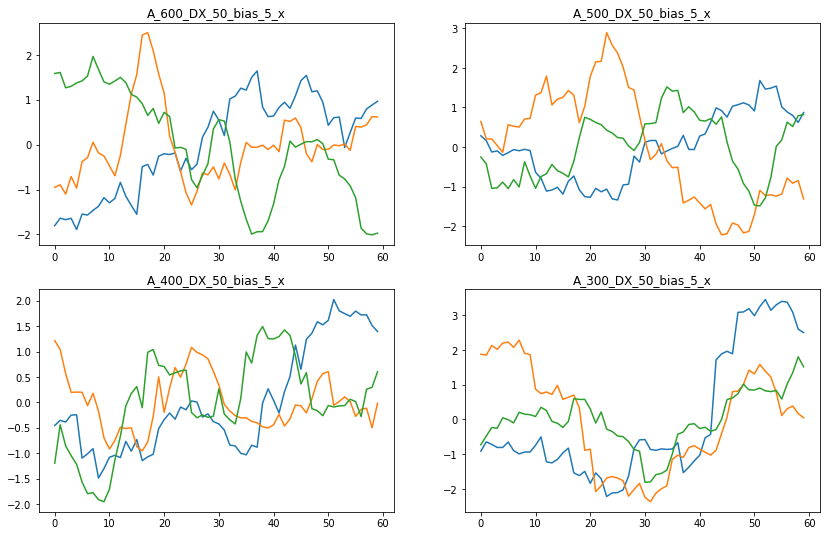

In [35]:
# DATA COMPARISON
fig1, ax1 = plt.subplots(len(data)//2,2,figsize=(14,9))
ax1 = ax1.flatten()
i=0
for k in data:
    ax1[i].plot(data[k][0])
    ax1[i].plot(data[k][1])
    ax1[i].plot(data[k][2])
    ax1[i].set_title(k)
    i += 1

plt.show()

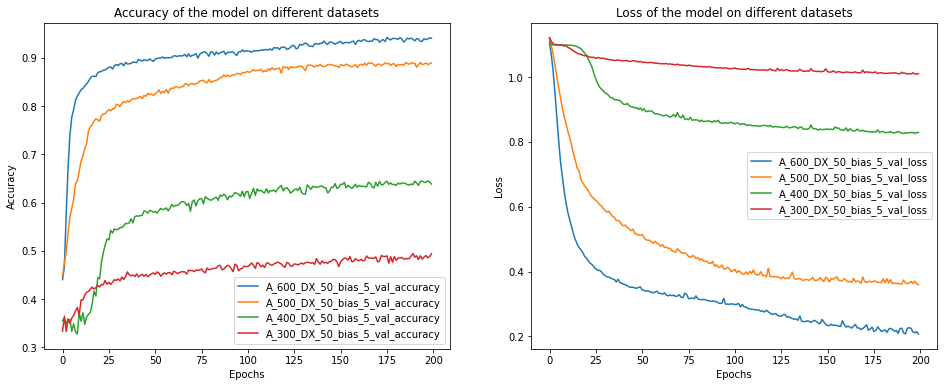

In [29]:
fig2, ax2 = plt.subplots(1,2,figsize=(16,6))
for key in keys:
    if 'accuracy' in key:
        ax2[0].plot(plots[key], label=key)
        ax2[0].set_xlabel('Epochs')
        ax2[0].set_ylabel('Accuracy')
        ax2[0].set_title('Accuracy of the model on different datasets')
        ax2[0].legend()
    if 'loss' in key:
        ax2[1].plot(plots[key], label=key)
        ax2[1].set_xlabel('Epochs')
        ax2[1].set_ylabel('Loss')
        ax2[1].set_title('Loss of the model on different datasets')
        ax2[1].legend()
plt.show()

As it is possible to see, changing the amplitude of the perturbation, and so reducing the ratio signal-noise, the consequence on the model are visible: already with the modification 500 -> 400, the accuracy of the model has decreased, while the total loss turns out to be much bigger. Anyway, the behaviour of the model is very clear, in the sense that its efficiency decreases with the amplitude of the "pulse", while for A > 500, the results are quite similar, meaning that the model itself has an intrinsec limit.

It is better to precise that, even the test has been done with model NCONV=1, similar results can be get with other models (the only important difference is between A=600 and A=500, that is bigger than the one in this case).